# Project 3: Web APIs & Classification

## Problem Statement

"Men are from mars, women are from venus"

As users from subreddit AskMen and AskWomen expresses themselves differently, how can we accurately differentiate them through the use of languages or words?


## Executive Summary

This report provides an inference and evaluation of the model through the use of various natural language processing technique to differentiate between reddit askmen and askwomen subreddits. Methods of inference includes detailed look at top features, confusion matrix, sensitivity, specificity, precison and ROC scores.

Results of model analysed shows that there are some common and frequent words used by the opposite sex. For AskMen's subreddit, words like 'men','girlfriend','girl','guy' are being used together to distinct the AskMen's post. Likewise, words like 'ladies','women','partner','feel' are amongst the words that differentiate AskWomen's post. Through the evaluation of precision, it shows that the model has correctly classified 77% of the 555 unseen subreddit posts.

The report finds the performance of the model not reaching it's full potential as there are signs of overfitting of training models. The area of weakness can be improved by collection of more datas for training of the model to drive the variance down. In addition, stop-words can be further refine by adding more helping verbs to reduce the number of features. Lastly, we can also consider to eliminate features with extremely low frequency.

It should be highlighted the fact that the project conducted has some limitations. Firstly, assumptions has been made that the majority of AskWomen's subreddit users is mostly women and Askmen's subreddit users is men. There might be instances that opposite sex can contribute to any of the subreddit and the posts has been taken to train the model.

### Contents:
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Cleaning](#Data-Cleaning)
- [Pre-Processing](#Pre-Processing)
- [LogisticRegression Model](#LogisticRegression-Model)
- [Naive Bayes Model](#Naive-Bayes-Model)
- [Inferential Visualization](#Inferential-Visualization)

## Exploratory Data Analysis

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import eli5

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import feature_selection

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# display max columns
pd.set_option('display.max_columns',None)

%matplotlib inline

C:\Users\gchoo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\gchoo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


### AskMen

In [2]:
# Select neccesary columns

askmen = pd.read_csv('datasets/askmen.csv')
askmen = askmen[['subreddit','selftext','title']]
askmen.head()

,subreddit,selftext,title
0,AskMen,"Like, for real, it's fun.","Men of reddit who don't comment on posts, why ..."
1,AskMen,Background story: I've been dating my current ...,I cheated and I feel like crap. Not sure how t...
2,AskMen,NaN,I went to hug a girl and she grabbed my hand a...
3,AskMen,Basically it goes like this. Somebody posts a...,"Wanna play the, ""how filthy can we make this t..."
4,AskMen,"Sup, shitladies. We need to talk. \n\nI'm remo...","THERE WILL BE NO MORE ""HOW CAN I MAKE MY SO FE..."


In [3]:
askmen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  925 non-null    object
 1   selftext   608 non-null    object
 2   title      925 non-null    object
dtypes: object(3)
memory usage: 21.8+ KB


In [4]:
askmen.isnull().sum()

subreddit      0
selftext     317
title          0
dtype: int64

In [5]:
askmen.shape

(925, 3)

### AskWomen

In [6]:
# Select neccesary columns

askwomen = pd.read_csv('datasets/askwomen.csv')
askwomen = askwomen[['subreddit','selftext','title']]
askwomen.head()

,subreddit,selftext,title
0,AskWomen,NaN,"As an introvert, how do you feel about this qu..."
1,AskWomen,NaN,"What is the most intimate, non-sex thing you d..."
2,AskWomen,NaN,"What do women do, that men would never think a..."
3,AskWomen,NaN,"Women who gave ""nice guys"" a chance how did it..."
4,AskWomen,"What made a guy once think you wanted him, whi...",What are some things that guys misinterpret fr...


In [7]:
askwomen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  925 non-null    object
 1   selftext   357 non-null    object
 2   title      925 non-null    object
dtypes: object(3)
memory usage: 21.8+ KB


In [8]:
askwomen.isnull().sum()

subreddit      0
selftext     568
title          0
dtype: int64

In [9]:
askwomen.shape

(925, 3)

## Data Cleaning

### AskMen

In [10]:
# Concat title with selftext 

askmen['selftext'] = askmen['selftext'].str.cat(askmen['title'],na_rep='')

In [11]:
askmen.head()

,subreddit,selftext,title
0,AskMen,"Like, for real, it's fun.Men of reddit who don...","Men of reddit who don't comment on posts, why ..."
1,AskMen,Background story: I've been dating my current ...,I cheated and I feel like crap. Not sure how t...
2,AskMen,I went to hug a girl and she grabbed my hand a...,I went to hug a girl and she grabbed my hand a...
3,AskMen,Basically it goes like this. Somebody posts a...,"Wanna play the, ""how filthy can we make this t..."
4,AskMen,"Sup, shitladies. We need to talk. \n\nI'm remo...","THERE WILL BE NO MORE ""HOW CAN I MAKE MY SO FE..."


In [12]:
# Askmen 

askmen.head()
askmen = askmen[['subreddit','selftext']]
askmen.head()

,subreddit,selftext
0,AskMen,"Like, for real, it's fun.Men of reddit who don..."
1,AskMen,Background story: I've been dating my current ...
2,AskMen,I went to hug a girl and she grabbed my hand a...
3,AskMen,Basically it goes like this. Somebody posts a...
4,AskMen,"Sup, shitladies. We need to talk. \n\nI'm remo..."


In [13]:
askmen.shape

(925, 2)

In [14]:
# Check for duplicates

askmen.duplicated(subset='selftext').sum()

0

In [15]:
# Check null values

askmen.isnull().sum()

subreddit    0
selftext     0
dtype: int64

### AskWomen

In [16]:
# Concat title with selftext 

askwomen['selftext'] = askwomen['selftext'].str.cat(askwomen['title'],na_rep = '')

In [17]:
# Askwomen 

askwomen.head()
askwomen = askwomen[['subreddit','selftext']]
askwomen.head()

,subreddit,selftext
0,AskWomen,"As an introvert, how do you feel about this qu..."
1,AskWomen,"What is the most intimate, non-sex thing you d..."
2,AskWomen,"What do women do, that men would never think a..."
3,AskWomen,"Women who gave ""nice guys"" a chance how did it..."
4,AskWomen,"What made a guy once think you wanted him, whi..."


In [18]:
# Check for duplicates

askwomen.duplicated(subset='selftext').sum()

3

In [19]:
# Drop Duplicates

askwomen.drop_duplicates(subset='selftext',inplace=True)
askwomen.shape

(922, 2)

In [20]:
# Check null values

askwomen.isnull().sum()

subreddit    0
selftext     0
dtype: int64

In [21]:
# Concat askmen and askwomen

df = pd.concat([askmen,askwomen],axis=0)

In [22]:
# reset index

df.reset_index(drop=True,inplace=True)

In [23]:
df.shape

(1847, 2)

## Pre-Processing

In [24]:
'''
Convert AskMen & AskWomen into binary labels:

0 for AskWomen
1 for AskMen
'''

df['subreddit'] = df['subreddit'].map({'AskMen': 1,'AskWomen': 0})

In [25]:
df.dtypes

subreddit     int64
selftext     object
dtype: object

In [26]:
df.head()

,subreddit,selftext
0,1,"Like, for real, it's fun.Men of reddit who don..."
1,1,Background story: I've been dating my current ...
2,1,I went to hug a girl and she grabbed my hand a...
3,1,Basically it goes like this. Somebody posts a...
4,1,"Sup, shitladies. We need to talk. \n\nI'm remo..."


In [27]:
# Baseline score

df['subreddit'].value_counts(normalize=True)

1    0.500812
0    0.499188
Name: subreddit, dtype: float64

In [28]:
X = df[['selftext']]
y = df['subreddit']

In [29]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    stratify = y)
                                        

In [30]:
X_train.shape

(1292, 1)

In [31]:
# Show X_train selftext

X_train['selftext']

1664    Mothers of reddit, what’s one thing you wish y...
1022    What's a memory from your childhood that stick...
1367    What's the lamest thing you ever did to get a ...
632         Guys who've had Sugar Moms, what was it like?
685     Attention cuckolds and cuckqueans of /r/AskMen...
                              ...                        
352     I’m referring to families where the father was...
673     That's what I'm feeling right now. I just want...
532     Men of Reddit: what made you go from not wanti...
871     tl;dr - I feel I can't make any mistakes in li...
1516    It's up to you whether this change suddenly oc...
Name: selftext, Length: 1292, dtype: object

In [32]:
X_test.shape

(555, 1)

In [33]:
# Show X_test selftext

X_test['selftext']

1570    Something so embarrassing, you questioned your...
1312    I'm on day 5 of no shower, and I can't bring m...
1086    I have been feeling kind of depressed about al...
253     Men, what do you do when you're super lonely, ...
1149    What is a common object that clearly was not d...
                              ...                        
857     With my first girlfriend though, this still ma...
759     what is something that not many women realize ...
695     Especially in this gendered subreddit. \n\n"He...
784     Which one of you is the 400 pound guy hacking ...
475     How does someones level of education play into...
Name: selftext, Length: 555, dtype: object

In [34]:
# Check for HTML code artifacts

X_train['selftext'][1470]

"A common stereotype is men 'protecting' women - but have you ever been in a situation where you 'protected' a male from something/someone? What's your story?"

In [35]:
# Instantiate lemmatizer. 
lemmatizer = WordNetLemmatizer()

# Create a function to clean selftext
def cleaning(text):
    
    # Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]"," ", text)

    # Convert to lower case and split into individual words
    words = letters_only.lower().split()
    
    # Lemmatizing of words
    lemmatized_words = [lemmatizer.lemmatize(w,pos="v") for w in words]
    
    # Join words back
    new_words = " ".join(lemmatized_words)
    
    return new_words

In [36]:
# Initialize an empty list to hold the clean reviews.
X_train_clean = []
X_test_clean = []

# Instantiate the counter
counter = 0

# Run through each row in X_train selftext
for row in X_train['selftext']:
    
    # Clean the text and append to X_train_clean
    X_train_clean.append(cleaning(row))
    
# Run through each row in X_test selftest
for row in X_test['selftext']:
    
    # Clean the text and append to X_test_clean
    X_test_clean.append(cleaning(row))

## LogisticRegression Model

### Using CountVectorizer

In [37]:
# add subreddit name to english stopwords to better train model

from sklearn.feature_extraction import text

my_stop_words = text.ENGLISH_STOP_WORDS.union(["askmen","askwomen","did","wa","ve"])

In [39]:
cvec = CountVectorizer(stop_words=my_stop_words)

In [41]:
# Fit our CountVectorizer on the training data into dataframe to get the max number of features.

count_cvec = pd.DataFrame(cvec.fit_transform(X_train_clean).todense(),columns = cvec.get_feature_names())
count_cvec.shape

(1292, 5348)

In [42]:
vec = CountVectorizer(stop_words=my_stop_words)

In [43]:
clf = LogisticRegression()

In [44]:
pipe_clf = make_pipeline(vec,clf)

In [45]:
# Hyperparameters

pipe_clf_params = {
    'countvectorizer__max_features': [500,1_000,1_500],
    'countvectorizer__min_df': [2, 3],
    'countvectorizer__max_df': [.9, .95],
    'countvectorizer__ngram_range': [(1,1), (1,2)],
    'logisticregression__C':[0.8,0.7,0.6]
}

In [46]:
# Instantiate GridSearchCV.

gs_clf = GridSearchCV(pipe_clf, 
                  param_grid=pipe_clf_params, 
                  cv=5)

In [47]:
# Fit GridSearch to training data.

gs_clf.fit(X_train_clean, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('countvectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                 

In [48]:
# Gridsearch best score

gs_clf.best_score_

0.736823201939481

In [49]:
# Get the best hyperparameters

gs_clf.best_params_

{'countvectorizer__max_df': 0.9,
 'countvectorizer__max_features': 1500,
 'countvectorizer__min_df': 2,
 'countvectorizer__ngram_range': (1, 1),
 'logisticregression__C': 0.6}

In [50]:
# Save the best model 

gs_clf_model = gs_clf.best_estimator_

In [51]:
# Score model on training set

gs_clf_model.score(X_train_clean,y_train)

0.9272445820433437

In [52]:
# Score model on test set

gs_clf_model.score(X_test_clean,y_test)

0.772972972972973

In [53]:
# Get top features in the model

eli5.show_weights(gs_clf_model.named_steps['logisticregression'], vec=gs_clf_model.named_steps['countvectorizer'], top=(10,10),target_names=y_test)

Weight?,Feature
+1.462,men
+1.362,girlfriend
+1.220,girl
+1.178,wife
+1.119,guy
+1.004,honest
+0.937,father
+0.925,post
+0.923,listen
+0.869,advice


- The train accuracy of the model is 92% and test accuracy is 77%. Hence the model is overfitted as the model has higher accuracy on the training set than the test set.

### Using TfidVectorizer

In [54]:
# Set up pipeline

tvec = TfidfVectorizer(stop_words=my_stop_words)

lr = LogisticRegression()

pipe_tvec = make_pipeline(tvec,lr)

In [55]:
# Set the pipe params

pipe_tvec_params = {
    'tfidfvectorizer__max_features': [500,1_000,1_500],
    'tfidfvectorizer__min_df': [2, 3],
    'tfidfvectorizer__max_df': [.9, .95],
    'tfidfvectorizer__ngram_range': [(1,1), (1,2)],
    'logisticregression__C':[0.8,0.7,0.6]
}

In [56]:
# Instantiate GridSearchCV.

gs_tfid = GridSearchCV(pipe_tvec, 
                  param_grid=pipe_tvec_params, 
                  cv=5)

In [57]:
# Fit GridSearch to training data.

gs_tfid.fit(X_train_clean, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                               

In [58]:
# Gridsearch best score

gs_tfid.best_score_

0.7492442608721679

In [59]:
# Get the best hyperparameters

gs_tfid.best_params_

{'logisticregression__C': 0.8,
 'tfidfvectorizer__max_df': 0.9,
 'tfidfvectorizer__max_features': 1500,
 'tfidfvectorizer__min_df': 3,
 'tfidfvectorizer__ngram_range': (1, 1)}

In [60]:
# Save the best model 

gs_tfid_model = gs_tfid.best_estimator_

In [61]:
# Score model on training set

gs_tfid_model.score(X_train_clean,y_train)

0.8792569659442725

In [62]:
# Score model on testing set

gs_tfid_model.score(X_test_clean,y_test)

0.7747747747747747

In [63]:
# Predictions

predictions_tfid = gs_tfid_model.predict(X_test_clean)

In [64]:
# Generate a confusion matrix function

confusion_matrix(y_test,predictions_tfid)

array([[214,  63],
       [ 62, 216]], dtype=int64)

In [65]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions_tfid).ravel()

In [66]:
# 
print("True Negatives: " + str(tn))
print("False Positives: " + str(fp))
print("False Negatives: " + str(fn))
print("True Positives: " + str(tp))

True Negatives: 214
False Positives: 63
False Negatives: 62
True Positives: 216


In [67]:
# Get top features in the model

eli5.show_weights(gs_tfid_model.named_steps['logisticregression'], vec=gs_tfid_model.named_steps['tfidfvectorizer'], top=(10,10),target_names=y_test)

Weight?,Feature
+2.386,guy
+2.231,men
+2.207,girl
+1.776,just
+1.714,girlfriend
+1.493,wife
+1.404,advice
+1.255,post
+1.232,edit
+1.087,father


- The TfidfVectorizer has an train accuracy of 92% and test score of 77%. 
- The model is still overfitted.

## Naive Bayes Model

In [68]:
# Set up pipeline

tvec_nb = TfidfVectorizer(stop_words=my_stop_words)

nb = MultinomialNB()

pipe_nb = make_pipeline(tvec_nb,nb)

In [69]:
# Hyperparameters

pipe_nb_params = {
    'tfidfvectorizer__max_features': [500,1_000,1_500],
    'tfidfvectorizer__min_df': [2, 3],
    'tfidfvectorizer__max_df': [.9, .95],
    'tfidfvectorizer__ngram_range': [(1,1), (1,2)],
    'multinomialnb__alpha': [3,4,5,6]
}

In [70]:
# Instantiate GridSearchCV.

gs_nb = GridSearchCV(pipe_nb, 
                  param_grid=pipe_nb_params, 
                  cv=5)

In [71]:
# Fit GridSearch to training data.

gs_nb.fit(X_train_clean, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                               

In [72]:
# Gridsearch best score

gs_nb.best_score_

0.7190536051001166

In [73]:
# Get the best hyperparameters

gs_nb.best_params_

{'multinomialnb__alpha': 6,
 'tfidfvectorizer__max_df': 0.9,
 'tfidfvectorizer__max_features': 500,
 'tfidfvectorizer__min_df': 3,
 'tfidfvectorizer__ngram_range': (1, 2)}

In [74]:
# Save the best model 

gs_nb_model = gs_nb.best_estimator_

In [75]:
# Score model on training set

gs_nb_model.score(X_train_clean,y_train)

0.8080495356037152

In [76]:
# Score model on test set

gs_nb_model.score(X_test_clean,y_test)

0.7225225225225225

In [77]:
# Predictions

predictions_nb = gs_nb_model.predict(X_test_clean)

In [78]:
# Generate a confusion matrix function

confusion_matrix(y_test,predictions_nb)

array([[182,  95],
       [ 59, 219]], dtype=int64)

In [79]:
tn_nb, fp_nb, fn_nb, tp_nb = confusion_matrix(y_test, predictions_nb).ravel()

In [80]:
print("True Negatives: " + str(tn_nb))
print("False Positives: " + str(fp_nb))
print("False Negatives: " + str(fn_nb))
print("True Positives: " + str(tp_nb))

True Negatives: 182
False Positives: 95
False Negatives: 59
True Positives: 219


In [81]:
#prob for positive class
pos_class_prob_sorted = gs_nb_model.named_steps['multinomialnb'].feature_log_prob_[1, :].argsort()
#prob for negative class
neg_class_prob_sorted = gs_nb_model.named_steps['multinomialnb'].feature_log_prob_[0, :].argsort()

#getting the top features 
neg_top_features = np.take(gs_nb_model.named_steps['tfidfvectorizer'].get_feature_names(), neg_class_prob_sorted)
pos_top_features = np.take(gs_nb_model.named_steps['tfidfvectorizer'].get_feature_names(), pos_class_prob_sorted)

In [82]:
# Top 10 positive and negative features

print(f'positive: {pos_top_features[:-11:-1]}')
print(f'negative: {neg_top_features[:-11:-1]}')

positive: ['men' 'like' 'just' 'guy' 'make' 'feel' 'edit' 'think' 'want' 'don']
negative: ['women' 'make' 'ladies' 'like' 'partner' 'think' 'feel' 'men' 'reddit'
 'thing']


- The Naive Bayes model return an lower train accuracy of 88% and test accuracy of 73%. 
- The Naive Bayes model is overfitted too

## Inferential Visualization

- Here we will compare the sensitivity, specificity, recall and ROC curve of the two models.

### Top 5 askmen & askwomen words
**CountVectorizer*

![](./image/topfeature.png)

### Naive Bayes

In [83]:
# Specificity of Naive Bayes Model

spec_nb = tn_nb / (tn_nb + fp_nb)

print(f'Specificity: {round(spec_nb,4)}')

Specificity: 0.657


In [84]:
# Sensitivity of Naive Bayes Model

sens_nb = tp_nb / (tp_nb + fn_nb)

print(f'Sensitivity: {round(sens_nb,4)}')

Sensitivity: 0.7878


In [85]:
# Precision of Naive Bayes Model

prec_nb = tp_nb / (tp_nb + fp_nb)

print(f'Precision: {round(prec_nb,4)}')

Precision: 0.6975


In [86]:
pred_proba = [i[1] for i in gs_nb_model.predict_proba(X_test_clean)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs' : pred_proba})

pred_df.head()

,true_values,pred_probs
1570,0,0.510263
1312,0,0.534766
1086,0,0.428461
253,1,0.543255
1149,0,0.327380


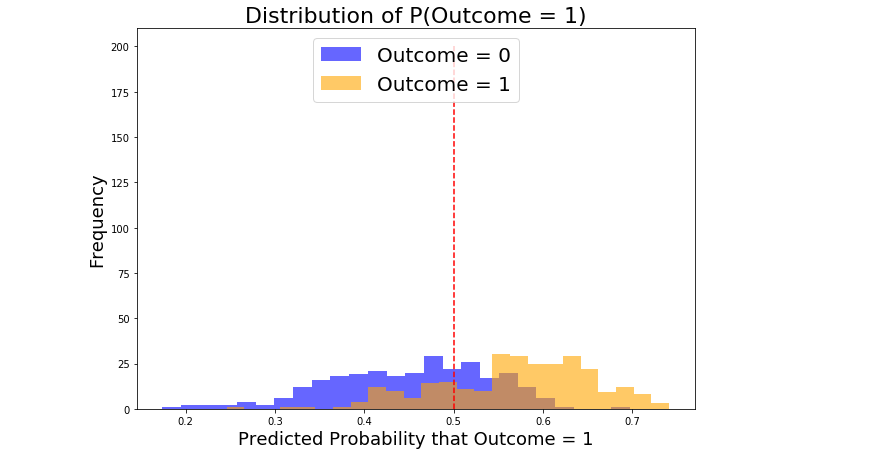

In [87]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 200,
           color = 'r',
           linestyle = '--')

# Add annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.00, 50),
             s = 'TN',
             size = 20)

plt.annotate(xy = (0.01, 10),
             s = 'FN',
             size = 20)

plt.annotate(xy = (0.95, 50),
             s = 'TP',
             size = 20)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20, loc='upper center');

In [88]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.829798976703114

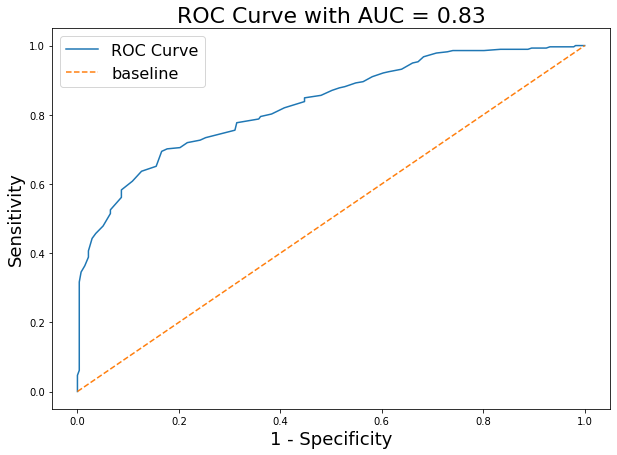

In [89]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

### Naive Bayes Inference 

|Sensitivity|Specificity|Precision|ROC score|TN|FP|FN|TP|
|:---|:---|:---|:---|:---|:---|:---|:---|
|0.7878|0.6570|0.6975|0.83|182|95|59|219

- The ROC curve shows sensitivity (True positive rate) against specificity (1 - False positive rate). 


- Using Naive Bayes model, the sensitivity is calculated to be 0.78 and specificity to be 0.65. It shows that the naive bayes model are good for identifying actual post of the askmen but they also come with a fairly high rate of false positives (predict to be askmen but in actual it's askwomen)


- Precision of 0.69 shows the 69% of Askmen that were correctly classified

### Logistic Regression

In [90]:
# Specificity of logistic Model

spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.7726


In [91]:
# Sensitivity of logistic Model

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.777


In [92]:
# Precision of Logistic Regression Model

prec = tp / (tp + fp)

print(f'Precision: {round(prec,4)}')

Precision: 0.7742


In [93]:
pred_proba_lr = [i[1] for i in gs_tfid_model.predict_proba(X_test_clean)]

pred_df_lr = pd.DataFrame({'true_values': y_test,
                        'pred_probs' : pred_proba_lr})

pred_df_lr.head()

,true_values,pred_probs
1570,0,0.480892
1312,0,0.614534
1086,0,0.363162
253,1,0.511880
1149,0,0.166338


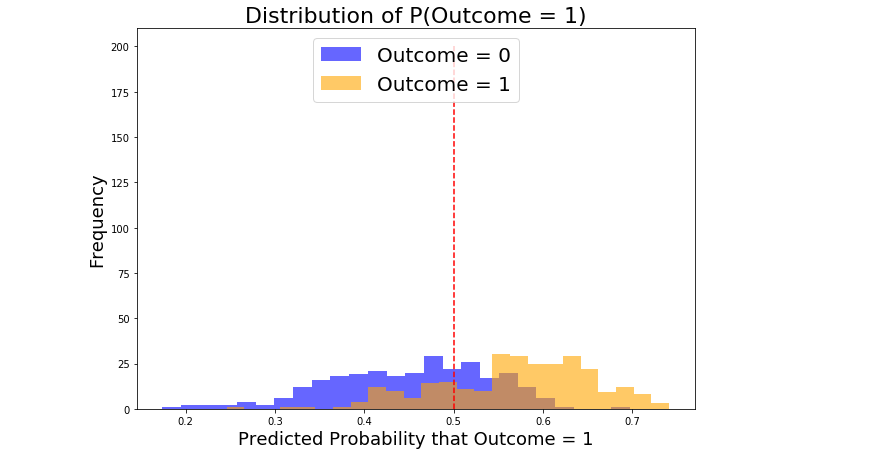

In [94]:
#Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df_lr['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = 0')
plt.hist(pred_df[pred_df_lr['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 200,
           color = 'r',
           linestyle = '--')

# Add annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.00, 50),
             s = 'TN',
             size = 20)

plt.annotate(xy = (0.01, 10),
             s = 'FN',
             size = 20)

plt.annotate(xy = (0.95, 50),
             s = 'TP',
             size = 20)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20, loc='upper center');

In [95]:
# ROC score 

roc_auc_score(pred_df_lr['true_values'], pred_df_lr['pred_probs'])

0.8450380489831961

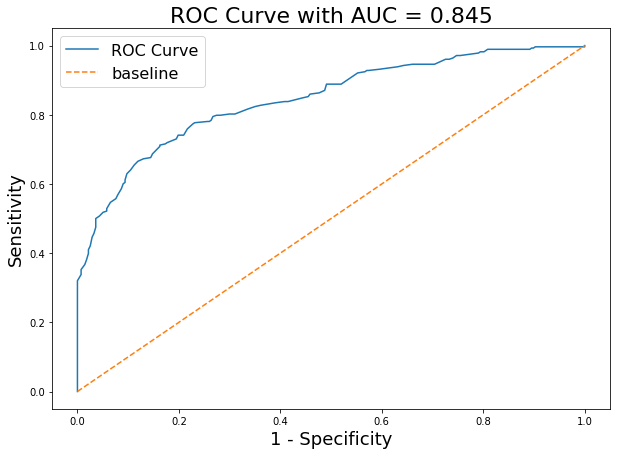

In [96]:
# Plot ROC Chart

# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df_lr, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df_lr, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df_lr["true_values"], pred_df_lr["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

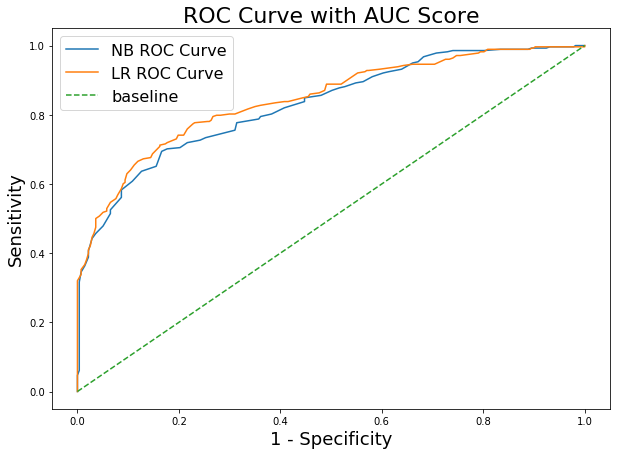

In [97]:
# Plot ROC Chart

# Create figure.
fig, ax = plt.subplots(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)


'''Logistic Regresion Model'''

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_lr_values = [TPR(pred_df_lr, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_lr_values = [FPR(pred_df_lr, 'true_values', 'pred_probs', prob) for prob in thresholds]

'''Naive Bayes Model'''

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot NB ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='NB ROC Curve')


# Plot LR ROC curve.
plt.plot(fpr_lr_values, # False Positive Rate on X-axis
         tpr_lr_values, # True Positive Rate on Y-axis
         label='LR ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC Score', fontsize=22,)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

### Inference
|Model|Sensitivity|Specificity|Precision|Accuracy|ROC score|TN|FP|FN|TP|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|Naive Bayes|0.7878|0.6570|0.6975|0.7225|0.83|182|95|59|219
|Logistic Regression|0.7770|0.7726|0.7742|0.7747|0.845|214|63|62|216


- The Logistic Regression is a better predictive model to use for this case as the AUC of the ROC is greater than the Naive Bayes model. This shows the Logistic Regression model is more capable of distinguishing between the two subreddits.


- In terms of accuracy, Logistic regression have higher accruacy score compared to the naive bayes model.


- Logistic Regression's precision of 0.77 shows the 77% of Askmen that were correctly classified compared to Naive Bayes precision of 69%


- ROC curves should be used when there are roughly equal numbers of observations for each class.